# Encoder-Decoder Model with Attention: 1 Layer LSTM & Scratch Embedding 
# (Char Level)

## Loading Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import re
import datetime
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import nltk.translate.bleu_score as bleu
import tensorflow as tf
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, Flatten, Activation 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Dataset

In [ ]:
data_path = '/content/drive/MyDrive/CS2/2.Datasets/'
model_path = '/content/drive/MyDrive/CS2/3.Models/4_1_Attention-Char-Scratch/'

In [ ]:
data = pd.read_csv(data_path + 'final_data.csv')
print(data.shape)
data.head()

(101717, 2)


,input_text,output_text
0,"Ofcouse , I love cheap fashion , fast fashion ...","Of course , I love cheap , fast fashion like f..."
1,If he want to listen to music that I do n't li...,If he wants to listen to music that I do n't l...
2,This happened because of the cultural differen...,This happened because of the cultural differen...
3,I 'm gon na earn much money to study abroad .,I 'm gon na earn enough money to study abroad .
4,It is not difficult for me but answer phones a...,It is not difficult for me but answering the p...


## Preprocess Data

In [ ]:
def clean(text):
    text = re.sub('<.*>', '', text)
    text = re.sub('\(.*\)', '', text)
    text = re.sub('\[.*\]', '', text)
    text = re.sub('{.*}', '', text)
    text = re.sub("[-+@#^/|*(){}$~`<>=_]","",text)
    text = text.replace("\\","")
    text = re.sub("\[","",text)
    text = re.sub("\]","",text)
    text = re.sub("[0-9]","",text)
    return text

data['input_text'] = data['input_text'].apply(lambda x: clean(x))
data['output_text'] = data['output_text'].apply(lambda x: clean(x))

In [ ]:
def preprocessing(data):
   
    data['input_text_length'] = data['input_text'].apply(len)
    data['output_text_length'] = data['output_text'].apply(len)

    data = data[data['input_text_length'] < 110]
    data = data[data['output_text_length'] < 110]

    data['output_text_in'] = '\t ' + data['output_text'].astype(str)
    data['output_text_out'] = data['output_text'].astype(str) + ' \n'

    data = data.drop(['input_text_length','output_text_length','output_text'], axis=1)
    return data

In [ ]:
data = preprocessing(data)

data.iloc[0]['output_text_in'] = str(data.iloc[0]['output_text_in'])+' \n'
data.iloc[0]['output_text_out'] = str(data.iloc[0]['output_text_out'])+' \n'

print('Shape of Dataset:', data.shape)
data.head()

Shape of Dataset: (91188, 3)


,input_text,output_text_in,output_text_out
0,"Ofcouse , I love cheap fashion , fast fashion ...","\t Of course , I love cheap , fast fashion lik...","Of course , I love cheap , fast fashion like f..."
1,If he want to listen to music that I do n't li...,\t If he wants to listen to music that I do n'...,If he wants to listen to music that I do n't l...
3,I 'm gon na earn much money to study abroad .,\t I 'm gon na earn enough money to study abro...,I 'm gon na earn enough money to study abroad ...
4,It is not difficult for me but answer phones a...,\t It is not difficult for me but answering th...,It is not difficult for me but answering the p...
5,The moment came when the world 's would have i...,\t The moment came when the world would have i...,The moment came when the world would have its ...


## Train Test Split

In [ ]:
train, test = train_test_split(data, test_size=0.1, random_state=42)
print('Shape of Train Data:', train.shape)
print('Shape of Test Data:', test.shape)

Shape of Train Data: (82069, 3)
Shape of Test Data: (9119, 3)


## Tokenization

In [ ]:
tokenizer_i = Tokenizer(filters="", char_level=True, lower=False)
tokenizer_o = Tokenizer(filters="", char_level=True, lower=False)

tokenizer_i.fit_on_texts(train['input_text'].values)
tokenizer_o.fit_on_texts(train['output_text_in'].values)

vocab_size_input = len(tokenizer_i.word_index.keys())
print('Input Vocab Size:', vocab_size_input)

vocab_size_output = len(tokenizer_o.word_index.keys())
print('Output Vocab Size:', vocab_size_output)

Input Vocab Size: 75
Output Vocab Size: 68


## Data Pipeline

In [ ]:
class Dataset:
    def __init__(self, data, tokenizer_i, tokenizer_o, max_len_enc, max_len_dec):
        self.encoder_inps = data['input_text'].values
        self.decoder_inps = data['output_text_in'].values
        self.decoder_outs = data['output_text_out'].values
        self.tokenizer_o = tokenizer_o
        self.tokenizer_i = tokenizer_i
        self.max_len_enc = max_len_enc
        self.max_len_dec = max_len_dec


    def __getitem__(self, i):
        self.encoder_seq = self.tokenizer_i.texts_to_sequences([self.encoder_inps[i]]) 
        self.decoder_inp_seq = self.tokenizer_o.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenizer_o.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_enc, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_dec, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_dec, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self):
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self): 
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tokenizer_i, tokenizer_o, 110, 110)
test_dataset  = Dataset(test, tokenizer_i, tokenizer_o, 110, 110)

train_dataloader = Dataloder(train_dataset, batch_size=512)
test_dataloader = Dataloder(test_dataset, batch_size=512)

print('Train Dataloader:', train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)
print('Test Dataloader:', test_dataloader[0][0][0].shape, test_dataloader[0][0][1].shape, test_dataloader[0][1].shape)

Train Dataloader: (512, 110) (512, 110) (512, 110)
Test Dataloader: (512, 110) (512, 110) (512, 110)


## Model Building

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''
    def __init__(self,in_vocab_size,embedding_dim,enc_units,input_length):
        super().__init__()
        self.in_vocab_size = in_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units = enc_units

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.in_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, name="Encoder_Embedding")
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")
        
    def call(self, input_sentences, training=True):
        input_embed = self.embedding(input_sentences)
        encoder_output, encoder_state_h, encoder_state_c = self.lstm(input_embed)
        return encoder_output, encoder_state_h, encoder_state_c

#-----------------------------------------------------------------------------------------------------------------------------------
class Attention(tf.keras.layers.Layer):
  '''
  Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function = scoring_function
    self.att_units = att_units

    if self.scoring_function == 'dot':
      pass

    if scoring_function == 'general':
      self.W = Dense(self.att_units)
      
    elif scoring_function == 'concat':
      self.W1 = Dense(self.att_units)
      self.W2 = Dense(self.att_units)
      self.Va = Dense(1)
  
  
  def call(self,decoder_hidden_state,encoder_output):
    if self.scoring_function == 'dot':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 2)
        score = tf.matmul(encoder_output, decoder_hidden_state)

    elif self.scoring_function == 'general':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 2)
        score = tf.matmul(self.W(encoder_output), decoder_hidden_state)

    elif self.scoring_function == 'concat':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        score = self.Va(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output)))

    attention_weight = tf.nn.softmax(score, axis=1)
    context_vector = tf.reduce_sum(attention_weight * encoder_output, axis=1)
    return context_vector, attention_weight

#-----------------------------------------------------------------------------------------------------------------------------------
class One_Step_Decoder(tf.keras.Model):
  def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
      super().__init__()
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units= dec_units
      self.score_fun = score_fun
      self.att_units = att_units

  def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, name="Decoder_Embedding")
        self.lstm = LSTM(self.dec_units, return_state=True, return_sequences=True, name="Decoder_LSTM")
        self.dense = Dense(self.tar_vocab_size)
        self.attention = Attention(self.score_fun, self.att_units)

  def call(self,input_to_decoder, encoder_output, state_h, state_c):
    
    target_embedd = self.embedding(input_to_decoder)

    context_vector, attention_weights = self.attention(state_h, encoder_output)
    context_vector = tf.expand_dims(context_vector, 1)

    decoder_input = tf.concat([target_embedd, context_vector], 2)

    decoder_output, decoder_final_state_h, decoder_final_state_c = self.lstm(decoder_input, initial_state=[state_h,state_c])

    output = self.dense(decoder_output)

    return tf.squeeze(output), decoder_final_state_h, decoder_final_state_c, attention_weights, tf.squeeze(context_vector)

#-----------------------------------------------------------------------------------------------------------------------------------
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun, att_units):
      super(Decoder, self).__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      self.one_step_decoder = One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units, self.score_fun, self.att_units)

   
    def call(self, input_to_decoder, encoder_output_state, decoder_hidden_state, decoder_cell_state):
      all_outputs = tf.TensorArray(tf.float32, size=tf.shape(input_to_decoder)[1], name="output_arrays")

      for timestep in range(tf.shape(input_to_decoder)[1]):
        output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.one_step_decoder(input_to_decoder[:,timestep:timestep+1], encoder_output_state, decoder_hidden_state, decoder_cell_state)
        all_outputs = all_outputs.write(timestep, output)

      all_outputs = tf.transpose(all_outputs.stack(), [1, 0, 2])
      return all_outputs

#-----------------------------------------------------------------------------------------------------------------------------------
class Encoder_Decoder(tf.keras.Model):
  def __init__(self, encoder_inputs_length, decoder_inputs_length, input_vocab_size, output_vocab_size, embedding_dim, enc_units, dec_units, att_units, batch_size, score_fun, name='Encoder-Decoder-Attention'):
    super().__init__(name=name)
    self.encoder = Encoder(in_vocab_size=input_vocab_size+1, embedding_dim=embedding_dim, enc_units=enc_units, input_length=encoder_inputs_length)
    self.decoder = Decoder(out_vocab_size=output_vocab_size+1, embedding_dim=embedding_dim, input_length=decoder_inputs_length, dec_units=dec_units, score_fun=score_fun, att_units=att_units)
    self.batch_size = batch_size

  def call(self,data):

    input, output = data[0], data[1]

    encoder_output, encoder_h, encoder_c = self.encoder(input)
    decoder_output = self.decoder(output, encoder_output, encoder_h, encoder_c)
    return decoder_output

## Custom Loss Function

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

## Model Training

In [ ]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=100)
es = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1, min_delta=0.001, monitor='val_loss', mode='min', restore_best_weights=True)

train_steps = train.shape[0]//512
valid_steps = test.shape[0]//512

model  = Encoder_Decoder(encoder_inputs_length=110,
                          decoder_inputs_length=110,
                          input_vocab_size=vocab_size_input,
                          output_vocab_size=vocab_size_output, 
                          embedding_dim=300, 
                          enc_units=64, 
                          dec_units=64, 
                          att_units=64,
                          batch_size=512,
                          score_fun='dot')

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=loss_function)

20 Epoch

In [ ]:
with tf.device('/device:GPU:0'):
    history20 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/20
160/160 [==============================] - 252s 1s/step - loss: 1.5306 - val_loss: 1.4071
Epoch 2/20
160/160 [==============================] - 204s 1s/step - loss: 1.3762 - val_loss: 1.3513
Epoch 3/20
160/160 [==============================] - 206s 1s/step - loss: 1.3271 - val_loss: 1.3007
Epoch 4/20
160/160 [==============================] - 203s 1s/step - loss: 1.2780 - val_loss: 1.2626
Epoch 5/20
160/160 [==============================] - 203s 1s/step - loss: 1.2447 - val_loss: 1.2329
Epoch 6/20
160/160 [==============================] - 203s 1s/step - loss: 1.2167 - val_loss: 1.2032
Epoch 7/20
160/160 [==============================] - 202s 1s/step - loss: 1.1865 - val_loss: 1.1745
Epoch 8/20
160/160 [==============================] - 203s 1s/step - loss: 1.1602 - val_loss: 1.1496
Epoch 9/20
160/160 [==============================] - 201s 1s/step - loss: 1.1360 - val_loss: 1.1260
Epoch 10/20
160/160 [==============================] - 200s 1s/step - loss: 1.1104 - val_lo

In [ ]:
model.save_weights(model_path + 'att20/' + 'attention20', save_format='tf') 

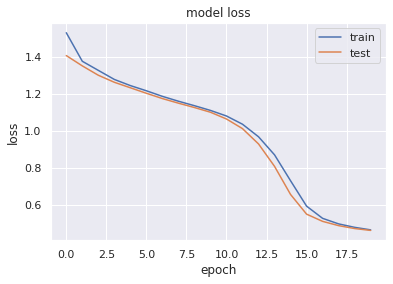

In [ ]:
plt.plot(history20.history['loss'])
plt.plot(history20.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

40 Epoch

In [ ]:
with tf.device('/device:GPU:0'):
    history40 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/20
160/160 [==============================] - 207s 1s/step - loss: 0.4536 - val_loss: 0.4504
Epoch 2/20
160/160 [==============================] - 205s 1s/step - loss: 0.4448 - val_loss: 0.4437
Epoch 3/20
160/160 [==============================] - 207s 1s/step - loss: 0.4375 - val_loss: 0.4367
Epoch 4/20
160/160 [==============================] - 206s 1s/step - loss: 0.4307 - val_loss: 0.4297
Epoch 5/20
160/160 [==============================] - 204s 1s/step - loss: 0.4250 - val_loss: 0.4248
Epoch 6/20
160/160 [==============================] - 210s 1s/step - loss: 0.4203 - val_loss: 0.4205
Epoch 7/20
160/160 [==============================] - 203s 1s/step - loss: 0.4155 - val_loss: 0.4162
Epoch 8/20
160/160 [==============================] - 203s 1s/step - loss: 0.4117 - val_loss: 0.4124
Epoch 9/20
160/160 [==============================] - 201s 1s/step - loss: 0.4080 - val_loss: 0.4097
Epoch 10/20
160/160 [==============================] - 202s 1s/step - loss: 0.4049 - val_lo

In [ ]:
model.save_weights(model_path + 'att40/' + 'attention40', save_format='tf') 

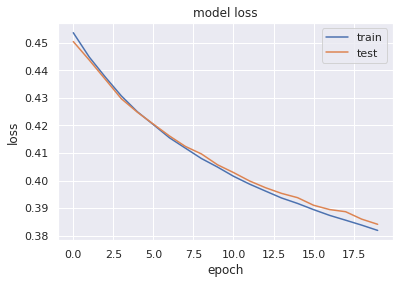

In [ ]:
plt.plot(history40.history['loss'])
plt.plot(history40.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
model.summary()

Model: "Encoder-Decoder-Attention"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_4 (Encoder)          multiple                  116240    
_________________________________________________________________
decoder_4 (Decoder)          multiple                  135009    
Total params: 251,249
Trainable params: 251,249
Non-trainable params: 0
_________________________________________________________________


60 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history60 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/20
160/160 [==============================] - 208s 1s/step - loss: 0.3803 - val_loss: 0.3849
Epoch 2/20
160/160 [==============================] - 209s 1s/step - loss: 0.3788 - val_loss: 0.3818
Epoch 3/20
160/160 [==============================] - 209s 1s/step - loss: 0.3777 - val_loss: 0.3801
Epoch 4/20
160/160 [==============================] - 206s 1s/step - loss: 0.3760 - val_loss: 0.3796
Epoch 5/20
160/160 [==============================] - 208s 1s/step - loss: 0.3749 - val_loss: 0.3789
Epoch 6/20
160/160 [==============================] - 205s 1s/step - loss: 0.3734 - val_loss: 0.3763
Epoch 7/20
160/160 [==============================] - 207s 1s/step - loss: 0.3723 - val_loss: 0.3753
Epoch 8/20
160/160 [==============================] - 203s 1s/step - loss: 0.3714 - val_loss: 0.3741
Epoch 9/20
160/160 [==============================] - 202s 1s/step - loss: 0.3703 - val_loss: 0.3729
Epoch 10/20
160/160 [==============================] - 204s 1s/step - loss: 0.3695 - val_lo

In [ ]:
model.save_weights(model_path + 'att60/' + 'attention60', save_format='tf') 

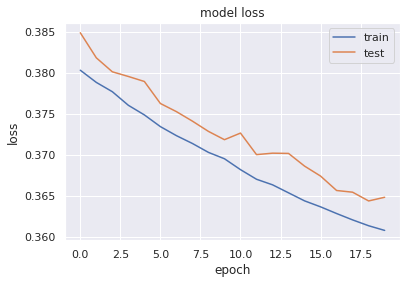

In [ ]:
plt.plot(history60.history['loss'])
plt.plot(history60.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

80 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history80 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/20
160/160 [==============================] - 204s 1s/step - loss: 0.3601 - val_loss: 0.3634
Epoch 2/20
160/160 [==============================] - 196s 1s/step - loss: 0.3591 - val_loss: 0.3630
Epoch 3/20
160/160 [==============================] - 197s 1s/step - loss: 0.3585 - val_loss: 0.3619
Epoch 4/20
160/160 [==============================] - 196s 1s/step - loss: 0.3580 - val_loss: 0.3624
Epoch 5/20
160/160 [==============================] - 196s 1s/step - loss: 0.3572 - val_loss: 0.3609
Epoch 6/20
160/160 [==============================] - 196s 1s/step - loss: 0.3566 - val_loss: 0.3606
Epoch 7/20
160/160 [==============================] - 195s 1s/step - loss: 0.3561 - val_loss: 0.3602
Epoch 8/20
160/160 [==============================] - 193s 1s/step - loss: 0.3555 - val_loss: 0.3596
Epoch 9/20
160/160 [==============================] - 193s 1s/step - loss: 0.3551 - val_loss: 0.3604
Epoch 10/20
160/160 [==============================] - 192s 1s/step - loss: 0.3545 - val_lo

In [ ]:
model.save_weights(model_path + 'att80/' + 'attention80', save_format='tf') 

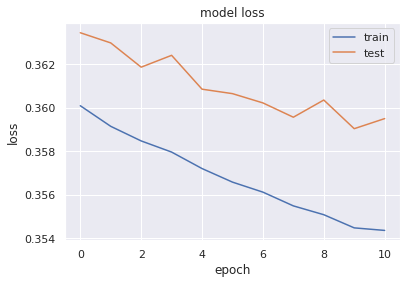

In [ ]:
plt.plot(history80.history['loss'])
plt.plot(history80.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Model Prediction

In [ ]:
def predict(input_sentence):

  batch_size = 1 
  DECODER_SEQ_LEN = 110
  predict_word_idx = np.zeros((1, 1))
  predict_word_idx[0,0] = 1
  predicted_sentence = ''

  input_sequence=tokenizer_i.texts_to_sequences([input_sentence])
  inputs=pad_sequences(input_sequence,maxlen=110,padding='post')
  inputs=tf.convert_to_tensor(inputs)

  enc_output, state_h, state_c = model.layers[0](inputs)

  for i in range(DECODER_SEQ_LEN):
      dec_output, state_h, state_c, attention_weights, context_vector = model.layers[1].one_step_decoder(predict_word_idx, enc_output, state_h, state_c)
      predict_word_idx = np.reshape(np.argmax(dec_output), (1, 1))
      predicted_sentence += '' + tokenizer_o.index_word[int(predict_word_idx)]

      if tokenizer_o.word_index['\n'] == predict_word_idx:
          return predicted_sentence
      dec_input = tf.expand_dims([predict_word_idx],0)
  return predicted_sentence

#----------------------------------------------------------------------------------------------------
import nltk.translate.bleu_score as bleu

def get_BLEU(model, train, test):
    total_bleu=0
    input_range = 100
    for i in range(0,input_range):
        output_sentence = train['output_text_out'].iloc[i]
        predicted_sentence = predict(train['input_text'].iloc[i])
        output_sentence = [output_sentence.split()]
        predicted_sentence = predicted_sentence.split()
        bleu_score = bleu.sentence_bleu(output_sentence, predicted_sentence)
        total_bleu += bleu_score
    train_avg_bleu = total_bleu/input_range

    total_bleu=0
    input_range = 100
    for i in range(0,input_range):
        output_sentence = test['output_text_out'].iloc[i]
        predicted_sentence = predict(test['input_text'].iloc[i])
        output_sentence = [output_sentence.split()]
        predicted_sentence = predicted_sentence.split()
        bleu_score = bleu.sentence_bleu(output_sentence, predicted_sentence)
        total_bleu += bleu_score
    test_avg_bleu = total_bleu/input_range

    print('Train BLEU Score:', train_avg_bleu)
    print('Test BLEU Score:', test_avg_bleu)

In [ ]:
print('SUMMARY OF AVERAGE BLEU SCORE AT EPOCHS')
print('-'*50)

print('Epoch 20')
model.load_weights(model_path + 'att20/' + 'attention20')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 40')
model.load_weights(model_path + 'att40/' + 'attention40')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 60')
model.load_weights(model_path + 'att60/' + 'attention60')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 80')
model.load_weights(model_path + 'att80/' + 'attention80')
get_BLEU(model, train, test)
print('='*50)

SUMMARY OF AVERAGE BLEU SCORE AT EPOCHS
--------------------------------------------------
Epoch 20
Train BLEU Score: 0.02745612211648893
Test BLEU Score: 0.06004211221613829
Epoch 40
Train BLEU Score: 0.053523445267987996
Test BLEU Score: 0.05580563192068619
Epoch 60
Train BLEU Score: 0.017915248934522874
Test BLEU Score: 0.054125939974752645
Epoch 80
Train BLEU Score: 0.012928059488686987
Test BLEU Score: 0.03551364317421554


In [ ]:
model.load_weights(model_path + 'att40/' + 'attention40')

Train

In [ ]:
for i in range(len(train[:5])):
    print("Input Text:", train['input_text'].iloc[i])
    print("Output Text:", train['output_text_out'].iloc[i])
    print("Predicted Text:", predict(train['input_text'].iloc[i]))
    print('='*120)

Input Text: I learned English first time .
Output Text: I learned English for the first time . 

Predicted Text: hr ea naeie ng sa ogtr ntii     o eal      o eal      o eate       o eate   

Input Text: Its inside was some stirred vegetable like sprouts and thin pork meat .
Output Text: Inside of it were some stirred vegetables like sprouts and thin pork meat . 

Predicted Text: hsie o i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i
Input Text: All I need to watch movies is just waiting .
Output Text: All I need to do to watch movies is just wait . 

Predicted Text: o   o et evnywrcie i ostn a us usbu  i ostnae  i ostnae.

Input Text: I think my english sentence is sheesy . . .
Output Text: I think my English sentences are cheesy . . . 

Predicted Text:  hvrytig sees hses hrey                etlns           etlns

Input Text: We were very depressed and dropped by a bar on the way back home .
Output Text: We were very depressed and

Test

In [ ]:
for i in range(len(test[:5])):
    print("Input Text:", test['input_text'].iloc[i])
    print("Output Text:", test['output_text_out'].iloc[i])
    print("Predicted Text:", predict(test['input_text'].iloc[i]))
    print('='*120)

Input Text: what about your father ?
Output Text: What about your father ? 

Predicted Text: hvr i rtr ot fuh raee   o  te otefrtr       o  te otefrtr       o  te otefrtr       o  te otefrtr       o  te 
Input Text: I and my brother started to find a good quality book .
Output Text: My brother and I started to find a good quality book . 

Predicted Text: o ada  o b o b o fre etrtn nt fne ada o  aa  o nad u o  aa  o   o ad ntbrtn   

Input Text: That 's way he 's always have a meal beyound midnight and talk me eat together .
Output Text: That way he 's always have a meal beyond midnight and talking , trying to get me to eat with him . 

Predicted Text: ha     a atalae hvra  ea byout o ea o ea o et tlk e og hr  o et tae o ea lwyte   

Input Text: Of course , someday the day will come to me if I meet my half . . .
Output Text: Of course , the day will come when I will meet my half . . . 

Predicted Text: i te o ate o am o et ee o am o ea o o emriis o m i                                   